# Opeonimages Object Detection System with GUI

In [ ]:
pip install scikit-image scikit-learn tensorflow utils seaborn

## 1. Preprocessing and Image Enhancement

In [1]:
import cv2
import numpy as np

def preprocess_image(image, target_size=(256, 256)):
    """
    Perform preprocessing and image enhancement.
    Returns original, grayscale, HSV, and binary images for further processing.
    """
    # Resize
    image_resized = cv2.resize(image, target_size)

    # Normalize to [0, 1]
    image_normalized = image_resized.astype(np.float32) / 255.0

    # Convert to grayscale
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

    # Denoise using Gaussian blur
    denoised = cv2.GaussianBlur(gray, (5, 5), 0)

    # Contrast enhancement using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast = clahe.apply(denoised)

    # Thresholding using Otsu
    _, binary_otsu = cv2.threshold(contrast, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations
    kernel = np.ones((3, 3), np.uint8)
    morph_open = cv2.morphologyEx(binary_otsu, cv2.MORPH_OPEN, kernel, iterations=1)
    morph_close = cv2.morphologyEx(morph_open, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Convert to HSV for possible later use
    hsv = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)

    return {
        "resized": image_resized,
        "normalized": image_normalized,
        "gray": gray,
        "contrast": contrast,
        "binary": morph_close,
        "hsv": hsv
    }


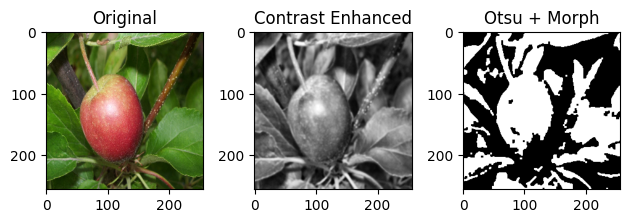

In [2]:
import matplotlib.pyplot as plt

img_path = "E:/Mariam/Uni Studing Material/L4(Second Term)/Computer Vision/project/Object Detection/openimages/apple/images/f765ed1b79eb1f1e.jpg"
image = cv2.imread(img_path)
results = preprocess_image(image)

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(results["resized"], cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Contrast Enhanced")
plt.imshow(results["contrast"], cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Otsu + Morph")
plt.imshow(results["binary"], cmap='gray')

plt.tight_layout()
plt.show()


## 2. Segmentation 

In [3]:
import cv2
import numpy as np
# Region Growing Function
def region_growing(img, seed, threshold=5):
    height, width = img.shape
    segmented = np.zeros_like(img)
    visited = np.zeros_like(img, dtype=bool)
    stack = [seed]
    seed_value = img[seed]

    while stack:
        x, y = stack.pop()
        if visited[x, y]:
            continue
        visited[x, y] = True
        if abs(int(img[x, y]) - int(seed_value)) < threshold:
            segmented[x, y] = 255
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < height and 0 <= ny < width:
                        stack.append((nx, ny))
    return segmented


In [4]:
# Watershed Segmentation
def watershed_segmentation(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphological cleanup
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Background and foreground
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Markers
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Apply watershed
    img_color = img.copy()
    markers = cv2.watershed(img_color, markers)

    # Draw red boundaries on the original image
    img_color[markers == -1] = [0, 0, 255]

    return img_color



In [5]:
# Modular Segmentation Function
import cv2
import numpy as np

def segment_image(image_dict, method="otsu"):
    """
    Segment an image using the selected method.
    - image_dict: output from preprocess_image
    - method: one of ['otsu', 'canny', 'kmeans', 'region_growing', 'watershed']
    """
    if method == "otsu":
        return image_dict["binary"]

    elif method == "canny":
        edges = cv2.Canny(image_dict["gray"], 100, 200)
        return edges

    elif method == "kmeans":
        img = image_dict["resized"]
        Z = img.reshape((-1, 3))
        Z = np.float32(Z)

        # KMeans criteria and clustering
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K = 3
        _, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Reconstruct clustered image
        centers = np.uint8(centers)
        clustered = centers[labels.flatten()].reshape(img.shape)
        return cv2.cvtColor(clustered, cv2.COLOR_BGR2GRAY)

    elif method == "region_growing":
        seed = (image_dict["gray"].shape[0] // 2, image_dict["gray"].shape[1] // 2)
        return region_growing(image_dict["gray"], seed)

    elif method == "watershed":
        return watershed_segmentation(image_dict["resized"])

    else:
        raise ValueError("Unsupported segmentation method.")



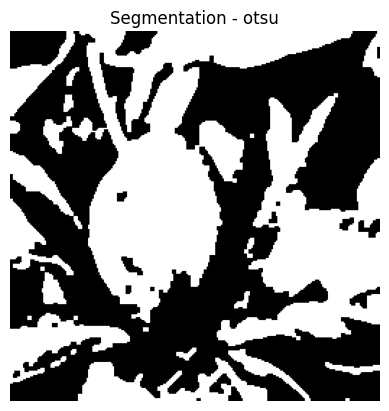

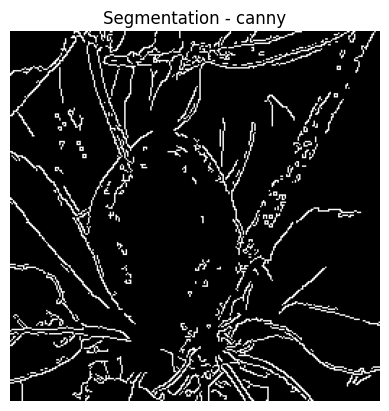

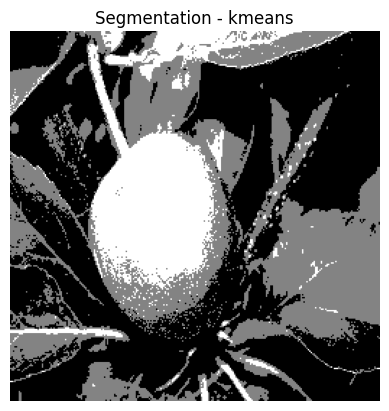

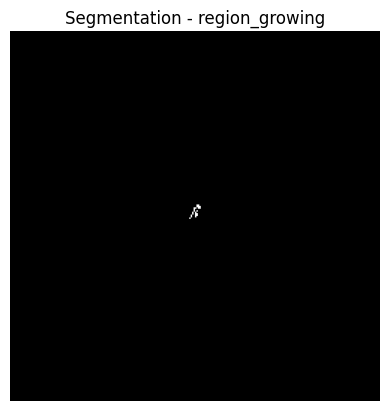

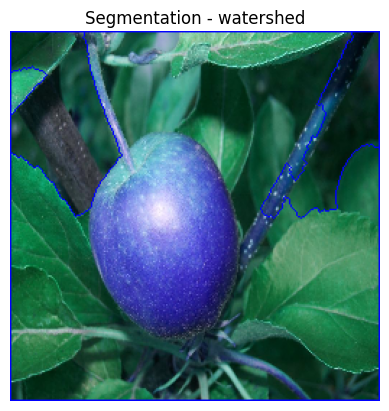

In [6]:
# Testing All Methods on One Image To chose the best one
methods = ["otsu", "canny", "kmeans", "region_growing", "watershed"]
for method in methods:
    segmented = segment_image(results, method)
    plt.imshow(segmented, cmap='gray')
    plt.title(f"Segmentation - {method}")
    plt.axis('off')
    plt.show()


### Based on the output the best way is watershed



## 3. Feature Extraction

    1. Read image and corresponding XML.

    2. Crop each annotated object ROI.

    3. Apply watershed segmentation to the ROI.

    4. Extract features from segmented ROI.

    5. Save feature vector and label.

In [ ]:

import os
import cv2
import numpy as np
from tqdm import tqdm

# Function to process the dataset
def process_dataset(input_root, output_root):
    os.makedirs(output_root, exist_ok=True)

    for subdir, _, files in os.walk(input_root):
        for filename in tqdm(files):
            if filename.lower().endswith(('.jpg', '.png')):
                input_path = os.path.join(subdir, filename)

                relative_path = os.path.relpath(subdir, input_root)
                output_subdir = os.path.join(output_root, relative_path)
                os.makedirs(output_subdir, exist_ok=True)

                out_path = os.path.join(output_subdir, filename)

                img = cv2.imread(input_path)
                if img is None:
                    continue

                segmented = watershed_segmentation(img)
                cv2.imwrite(out_path, segmented)


input_root = "E:/Mariam/Uni Studing Material/L4(Second Term)/Computer Vision/project/Object Detection/openimages"
output_root = "E:/Mariam/Uni Studing Material/L4(Second Term)/Computer Vision/project/Object Detection/openimages/openimages_masks"
process_dataset(input_root, output_root)


In [7]:
# Cropping ROIs based on XML bounding boxes
# So that feature extraction is focused only on labeled objects, not the full image.
import xml.etree.ElementTree as ET
import os
import cv2

def parse_pascal_voc(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    objects = []

    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        objects.append((label, xmin, ymin, xmax, ymax))

    return objects


In [8]:
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops
import numpy as np

def extract_features(image):
    # Convert to grayscale and HSV
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    features = []

    # 1. Color Histogram (HSV)
    for i in range(3):  # H, S, V
        hist = cv2.calcHist([hsv], [i], None, [32], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.extend(hist)

    # 2. Texture: Local Binary Pattern
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    (hist_lbp, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist_lbp = hist_lbp.astype("float")
    hist_lbp /= (hist_lbp.sum() + 1e-6)
    features.extend(hist_lbp)

    # 3. Texture: GLCM Properties
    glcm = graycomatrix(gray, [1], [0], symmetric=True, normed=True)
    features.append(graycoprops(glcm, 'contrast')[0, 0])
    features.append(graycoprops(glcm, 'correlation')[0, 0])
    features.append(graycoprops(glcm, 'homogeneity')[0, 0])
    features.append(graycoprops(glcm, 'ASM')[0, 0])

    # 4. Shape Features from largest contour
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
        x, y, w, h = cv2.boundingRect(c)
        aspect_ratio = float(w) / h
        features.extend([area, perimeter, aspect_ratio])
    else:
        features.extend([0, 0, 0])


    return np.array(features)


In [9]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [10]:
def draw_bounding_boxes(img, objects):
    for label, xmin, ymin, xmax, ymax in objects:
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(img, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (36, 255, 12), 2)
    return img

In [11]:
def unified_data_processing_with_bboxes(image_dir, annotation_dir, label_map, target_size=(64, 64)):
    images = []
    labels = []
    features_list = []
    bboxes = []

    for filename in tqdm(os.listdir(image_dir), desc=f"Processing {os.path.basename(image_dir)}"):
        if not filename.endswith(('.jpg', '.png')):
            continue

        image_path = os.path.join(image_dir, filename)
        xml_path = os.path.join(annotation_dir, os.path.splitext(filename)[0] + ".xml")

        if not os.path.exists(xml_path):
            continue

        img = cv2.imread(image_path)
        if img is None:
            continue

        height, width = img.shape[:2]
        objects = parse_pascal_voc(xml_path)

        for label, xmin, ymin, xmax, ymax in objects:
            if label not in label_map:
                continue

            roi = img[ymin:ymax, xmin:xmax]
            segmented = watershed_segmentation(roi)
            if segmented.shape[0] == 0 or segmented.shape[1] == 0:
                continue

            resized = cv2.resize(segmented, target_size)
            images.append(resized)

            features = extract_features(segmented)
            if features is not None and len(features) > 0:
                features_list.append(features)

            labels.append(label_map[label])

            x_min_norm = xmin / width
            y_min_norm = ymin / height
            x_max_norm = xmax / width
            y_max_norm = ymax / height
            bboxes.append([x_min_norm, y_min_norm, x_max_norm, y_max_norm])

    return images, features_list, labels, bboxes


In [12]:
label_map = {'apple': 0, 'banana': 1, 'car': 2, 'dog': 3, 'person': 4, 'bicycle': 5, 'chair': 6}
categories = list(label_map.keys())
root_dir = r"E:\Mariam\Uni Studing Material\L4(Second Term)\Computer Vision\project\Object Detection\openimages"
#root_dir = "E:\\Mariam\\Uni Studing Material\\L4(Second Term)\\Computer Vision\\project\\Object Detection\\openimages"
images, features, labels, bboxes = [], [], [], []

for category in categories:
    image_dir = os.path.join(root_dir, category, 'images')
    annotation_dir = os.path.join(root_dir, category, 'pascal')

    imgs, ftrs, lbls, bxs = unified_data_processing_with_bboxes(image_dir, annotation_dir, label_map)
    images.extend(imgs)
    features.extend(ftrs)
    labels.extend(lbls)
    bboxes.extend(bxs)

Processing images:   0%|          | 1/389 [00:00<00:58,  6.66it/s]

Processing images: 100%|██████████| 1000/1000 [02:02<00:00,  8.14it/s]


C:\Users\marim\AppData\Local\Temp\ipykernel_20452\582650114.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=np.bincount(labels), palette="viridis")


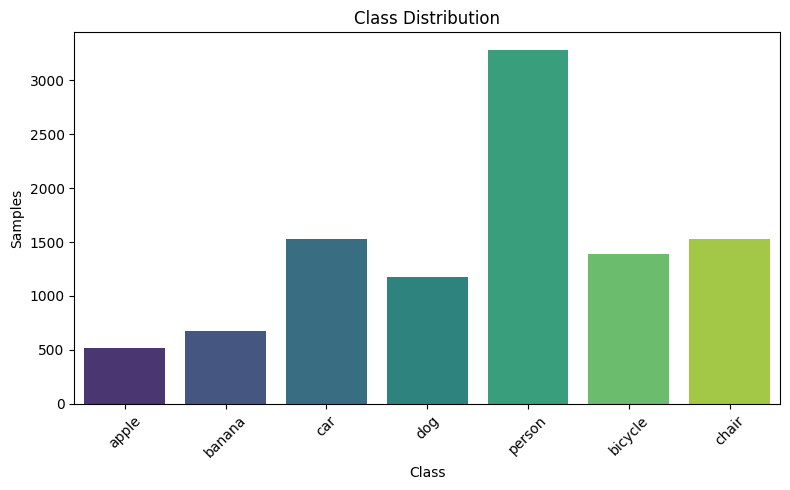

In [13]:
# ----- Label Distribution Before Balancing -----

plt.figure(figsize=(8, 5))
sns.barplot(x=categories, y=np.bincount(labels), palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
# Balance Dataset

features = np.array(features)
labels = np.array(labels)
images = np.array(images)

class_indices = defaultdict(list)
for idx, label in enumerate(labels):
    class_indices[label].append(idx)

target_count = 1700
selected_indices = []

for label, indices in class_indices.items():
    if len(indices) > target_count:
        selected = np.random.choice(indices, target_count, replace=False)
    else:
        selected = indices
    selected_indices.extend(selected)

np.random.shuffle(selected_indices)
features = features[selected_indices]
labels = labels[selected_indices]
images = images[selected_indices]
bboxes = np.array(bboxes)[selected_indices]
    
   


C:\Users\marim\AppData\Local\Temp\ipykernel_20452\582650114.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=np.bincount(labels), palette="viridis")


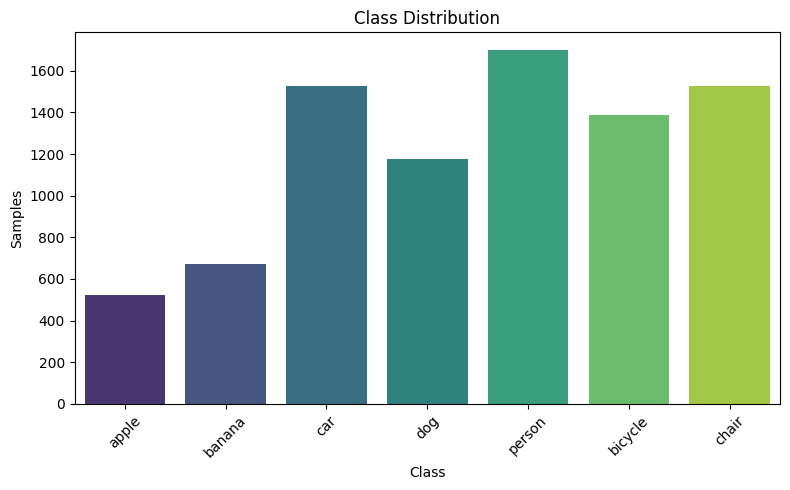

In [15]:
# ----- Label Distribution Before Balancing -----

plt.figure(figsize=(8, 5))
sns.barplot(x=categories, y=np.bincount(labels), palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# ----- Label Encoding -----

labels_cat = to_categorical(labels, num_classes=len(label_map))

# ----- Final Label + Bounding Box Combination -----

targets = np.concatenate([labels_cat, bboxes], axis=1)

# ----- Train/Test Split for CNN -----


import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def save_images_to_folders(images, labels, label_map, output_dir="output_images"):
    # Inverse label map: 0 -> 'apple', etc.
    inv_label_map = {v: k for k, v in label_map.items()}
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

    for subset_name, subset_images, subset_labels in [("train", X_train, y_train), ("test", X_test, y_test)]:
        for idx, (img, label) in enumerate(zip(subset_images, subset_labels)):
            class_name = inv_label_map[label]
            subset_class_dir = os.path.join(output_dir, subset_name, class_name)
            os.makedirs(subset_class_dir, exist_ok=True)
            
            filename = f"{class_name}_{idx}.jpg"
            save_path = os.path.join(subset_class_dir, filename)
            cv2.imwrite(save_path, img)

# Call the function
save_images_to_folders(images, labels, label_map, output_dir="E:/CV_Project/train_test_split")


X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, random_state=42)

## 4. Classification 

Techniques:

1. Traditional ML: Support Vector Classification. (SVC)

2. Deep Learning:

    - Custom Convolutional Neural Network (CNN)
    - Pretrained MobileNetV2


Test Accuracy: 70.58%

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70        90
           1       0.74      0.76      0.75       139
           2       0.86      0.80      0.83       317
           3       0.67      0.66      0.66       246
           4       0.68      0.69      0.69       368
           5       0.67      0.65      0.66       248
           6       0.64      0.69      0.66       295

    accuracy                           0.71      1703
   macro avg       0.71      0.71      0.71      1703
weighted avg       0.71      0.71      0.71      1703



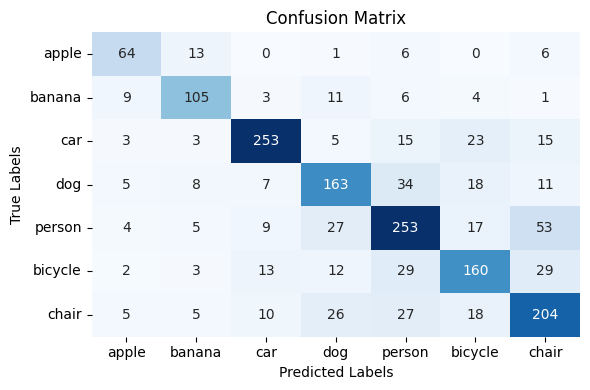

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Use flattened feature vectors and labels
X = np.array(features)
y = np.array(labels)

# 2. Preprocessing: Standardize features
X_scaled = StandardScaler().fit_transform(X)

# 3. Split dataset for ML
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. Train SVC Classifier
clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(X_train_ml, y_train_ml)

# 5. Evaluate the model
y_pred_ml = clf.predict(X_test_ml)

# Print accuracy
accuracy = accuracy_score(y_test_ml, y_pred_ml)
print(f"\nTest Accuracy: {accuracy:.2%}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_ml, y_pred_ml))

# Plot confusion matrix
cm = confusion_matrix(y_test_ml, y_pred_ml)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [18]:
import joblib

# Save the trained model
joblib.dump(clf, 'svc_classifier.pkl')

['svc_classifier.pkl']

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def create_detector(input_shape=(64, 64, 3), num_classes=7):
    inputs = Input(shape=input_shape)

    # Convolutional Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)

    # Convolutional Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)

    # Convolutional Block 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)

    # Convolutional Block 4
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2, 2)(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layers
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)

    # Outputs
    class_output = Dense(num_classes, activation='softmax', name='class_output')(x)
    bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)

    # Model
    model = Model(inputs, [class_output, bbox_output])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
        metrics={'class_output': 'accuracy'}
    )
    return model

In [20]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [21]:
# Train/test split
#X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(images, labels_cat, test_size=0.2, random_state=42)

y_train_class = y_train[:, :-4]
y_train_bbox = y_train[:, -4:]

model_cnn = create_detector(input_shape=(64, 64, 3), num_classes=7)
model_cnn.summary()

# Train the model
history = model_cnn.fit(
    X_train,
    {'class_output': y_train_class, 'bbox_output': y_train_bbox},
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[lr_scheduler]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 4, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ max_pooling2d_3[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 7)         │      1,799 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │      1,028 │ dropout[0][0]   

 Total params: 458,955 (1.75 MB)

 Trainable params: 457,995 (1.75 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 50s 204ms/step - bbox_output_loss: 0.0913 - class_output_accuracy: 0.4135 - class_output_loss: 1.6391 - loss: 3.8936 - val_bbox_output_loss: 0.0604 - val_class_output_accuracy: 0.4038 - val_class_output_loss: 1.6218 - val_loss: 2.8741 - learning_rate: 0.0010
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 36s 189ms/step - bbox_output_loss: 0.0587 - class_output_accuracy: 0.6219 - class_output_loss: 1.0451 - loss: 2.1136 - val_bbox_output_loss: 0.0475 - val_class_output_accuracy: 0.5977 - val_class_output_loss: 1.1428 - val_loss: 1.7370 - learning_rate: 0.0010
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 36s 187ms/step - bbox_output_loss: 0.0556 - class_output_accuracy: 0.6994 - class_output_loss: 0.8466 - loss: 1.3781 - val_bbox_output_loss: 0.0482 - val_class_output_accuracy: 0.7269 - val_class_output_loss: 0.8611 - val_loss: 1.1629 - learning_rate: 0.0010
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 44s 231ms/step - bbox_output_loss: 0.0515 - class_output_accura

In [23]:
results = model_cnn.evaluate(
    X_test, 
    {'class_output': y_test[:, :-4], 'bbox_output': y_test[:, -4:]},
    verbose=1
)

# Unpack results
total_loss, class_loss, bbox_loss, class_acc = results

print(f"Total Loss:         {total_loss:.4f}")
print(f"Class Loss:         {class_loss:.4f}")
print(f"BBox Loss (MSE):    {bbox_loss:.4f}")
print(f"Classification Acc: {class_acc:.4f}")


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - bbox_output_loss: 0.0462 - class_output_accuracy: 0.9544 - class_output_loss: 0.1657 - loss: 0.3036
Total Loss:         0.3113
Class Loss:         0.1728
BBox Loss (MSE):    0.0441
Classification Acc: 0.9489


In [ ]:
model_cnn.save("custom_cnn_model.h5")

In [28]:
# Load required libraries for MobileNet and visualization
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels_cat, test_size=0.2, random_state=42)

# Define MobileNetV2 model
def create_mobilenet_model(input_shape=(64, 64, 3), num_classes=7):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model_mobilenet = Model(inputs=base_model.input, outputs=predictions)

    model_mobilenet.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model_mobilenet

mobilenet_model = create_mobilenet_model(input_shape=(64, 64, 3), num_classes=7)
#mobilenet_model.summary()

# Train model
mobilenet_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate
test_loss, test_acc = mobilenet_model.evaluate(X_test, y_test)
test_acc



C:\Users\marim\AppData\Local\Temp\ipykernel_20452\331159280.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))


Epoch 1/5


c:\Users\marim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_364']
Received: inputs=Tensor(shape=(None, 64, 64, 3))
  warnings.warn(msg)


192/192 ━━━━━━━━━━━━━━━━━━━━ 150s 382ms/step - accuracy: 0.6702 - loss: 1.0773 - val_accuracy: 0.6505 - val_loss: 4.4397
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 67s 348ms/step - accuracy: 0.8049 - loss: 0.6194 - val_accuracy: 0.7283 - val_loss: 2.7234
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 77s 402ms/step - accuracy: 0.8844 - loss: 0.3522 - val_accuracy: 0.7004 - val_loss: 3.6264
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 100s 522ms/step - accuracy: 0.9008 - loss: 0.3153 - val_accuracy: 0.6579 - val_loss: 4.7590
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 108s 564ms/step - accuracy: 0.9210 - loss: 0.2337 - val_accuracy: 0.6373 - val_loss: 4.0154
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.6447 - loss: 3.4401


0.6388725638389587

In [29]:
mobilenet_model.save("mobilenet_model.keras")

In [30]:
# Compare Accuracy

print(f"SVC Accuracy: 70.58 % ")
print(f"Custom CNN Accuracy: 94.89 %")
print(f"MobileNetV2 Accuracy: 63.88 %")

SVC Accuracy: 70.58 % 
Custom CNN Accuracy: 94.89 %
MobileNetV2 Accuracy: 63.88 %


### We will use CNN to show example

In [31]:
xml_path = "E:/Mariam/Uni Studing Material/L4(Second Term)/Computer Vision/project/Object Detection/openimages/car/pascal/00e82dca4d06bd93.xml"

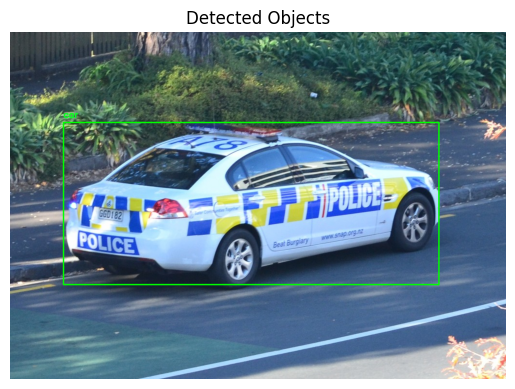

In [54]:
import matplotlib.pyplot as plt  
from utils import *

# openimages/banana/images/cc7497f20d88361a.jpg

image_path = "E:/Mariam/Uni Studing Material/L4(Second Term)/Computer Vision/project/Object Detection/openimages/car/images/00e82dca4d06bd93.jpg"

image = cv2.imread(image_path)
objects = parse_pascal_voc(xml_path)
boxed = draw_bounding_boxes(image.copy(), objects)
plt.imshow(cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB))
plt.title("Detected Objects")
plt.axis('off')
plt.show()


In [55]:
# Example: Get the file path for the first test image
image_path = test_paths[0]
print(f"File path for the first test image: {image_path}")

NameError: name 'test_paths' is not defined

In [ ]:

# -----------------------
# Load and preprocess the test image
# -----------------------


# openimages/dog/images/0ae28b5f3d9513a0.jpg


# openimages/person/images/00a01813890455b0.jpg
# openimages/dog/images/0b6304737968e40a.jpg
# openimages/chair/images/0ac256da33db51cc.jpg
# openimages/bicycle/images/00aeae02541ecc2e.jpg
# openimages/car/images/00aaf5c6d57a8670.jpg
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Configuration
IMG_SIZE = 64  # Must match the training size
LABEL_MAP = {0: "apple", 1: "banana", 2: "car", 3: "dog", 4: "person", 5: "bicycle", 6: "chair"}

# Load and recompile the model
model_cnn = load_model("custom_cnn_model.h5", custom_objects={'mse': MeanSquaredError()})
model_cnn.compile(optimizer='adam', loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'})

def preprocess_input_image(image_path):
    """
    Preprocess the input image for the CNN model.
    - Resize the image to match the training size.
    - Normalize pixel values to [0, 1].
    - Add a batch dimension.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at path: {image_path}")
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized.astype('float32') / 255.0
    img_batch = np.expand_dims(img_normalized, axis=0)  # Add batch dimension
    return img, img_batch

def predict_and_visualize(image_path):
    """
    Predict the class and bounding box for the input image using the CNN model.
    Draw the bounding box and display the result.
    """
    try:
        # Preprocess the input image
        original_image, input_image = preprocess_input_image(image_path)

        # Predict class probabilities and bounding box
        class_probs, bbox = model_cnn.predict(input_image)

        # Decode the predicted class
        predicted_class = np.argmax(class_probs[0])
        class_name = LABEL_MAP[predicted_class]
        confidence = class_probs[0][predicted_class]

        # Debug outputs
        print(f"Predicted class: {class_name} (Confidence: {confidence:.2f})")
        print(f"Raw bbox output: {bbox[0]}")

        # Convert bbox format (cx, cy, w, h) → (xmin, ymin, xmax, ymax)
        cx, cy, w, h = bbox[0]
        xmin = (cx - w / 2) * original_image.shape[1]
        ymin = (cy - h / 2) * original_image.shape[0]
        xmax = (cx + w / 2) * original_image.shape[1]
        ymax = (cy + h / 2) * original_image.shape[0]

        # Clip to image bounds
        xmin, ymin, xmax, ymax = map(lambda v: np.clip(v, 0, original_image.shape[1] - 1), [xmin, ymin, xmax, ymax])

        # Check if bounding box is valid
        if xmin >= xmax or ymin >= ymax:
            print("Warning: Invalid bounding box predicted. Skipping visualization.")
            return

        # Draw bounding box and label on the image
        cv2.rectangle(original_image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
        cv2.putText(original_image, f"{class_name} ({confidence:.2f})", (int(xmin), int(ymin) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (36, 255, 12), 2)

        # Convert BGR to RGB for visualization
        img_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Display the image
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Predicted: {class_name}")
        plt.show()

    except ValueError as e:
        print(e)

# Example usage
if __name__ == "__main__":
    # Single image testing
    # Select a random image from the test set
    random_index = 0  # Replace with any index
    image_path = "openimages/person/images/00a01813890455b0.jpg"  # Get the corresponding file path

    if os.path.exists(image_path):
        predict_and_visualize(image_path)
    else:
        print(f"Image not found: {image_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicted class: chair (Index: 6)


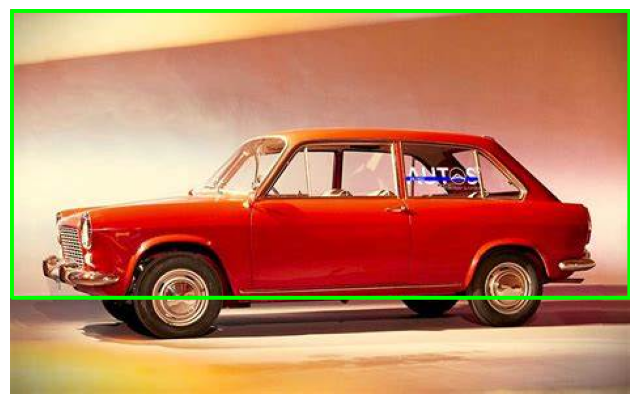

True

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Your label map
LABEL_MAP = {0: "apple", 1: "banana", 2: "car", 3: "dog", 4: "person", 5: "bicycle", 6: "chair"}

def prepare_image_for_cnn(image_path):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image from {image_path}")

    # Step 1: Segment the object (use your existing segmentation logic)
    segmented = watershed_segmentation(image)

    # Convert segmented result to grayscale (if it's not already)
    if len(segmented.shape) == 3:  # If the image has 3 channels (RGB)
        segmented_gray = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
    else:
        segmented_gray = segmented  # If it's already single-channel (grayscale)

    # Threshold the image to ensure it's binary (background=0, foreground=255)
    _, binary_segmented = cv2.threshold(segmented_gray, 127, 255, cv2.THRESH_BINARY)

    # Step 2: Manually extract ROI (bounding box based on contours)
    contours, _ = cv2.findContours(binary_segmented, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get bounding box around the largest contour (assuming it's the object of interest)
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        roi = image[y:y+h, x:x+w]  # Crop the region of interest
    else:
        raise ValueError("No contours found for ROI extraction")

    # Ensure it's 3-channel (convert grayscale to RGB if needed)
    if len(roi.shape) == 2:  # grayscale
        roi = cv2.cvtColor(roi, cv2.COLOR_GRAY2RGB)
    elif roi.shape[2] == 1:  # single channel
        roi = cv2.cvtColor(roi, cv2.COLOR_GRAY2RGB)

    # Step 3: Resize to 64x64 and normalize
    roi_resized = cv2.resize(roi, (64, 64))
    roi_normalized = roi_resized.astype('float32') / 255.0

    # Step 4: Add batch dimension
    input_img = np.expand_dims(roi_normalized, axis=0)

    return image, input_img, x, y, w, h

# Load model
from tensorflow.keras.models import load_model

model = load_model("custom_cnn_model.h5", compile=False)

# Prepare image
image_path = "./assets/OIP.jpeg"
image, input_img, x, y, w, h = prepare_image_for_cnn(image_path)

# Predict
class_pred, bbox_pred = model.predict(input_img)

# Get predicted class index
predicted_class_idx = np.argmax(class_pred)

# Get predicted class name using LABEL_MAP
predicted_class_name = LABEL_MAP.get(predicted_class_idx, "Unknown")

# Print predicted class name
print(f"Predicted class: {predicted_class_name} (Index: {predicted_class_idx})")

# Draw bounding box and class label on the image
cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box (green)
cv2.putText(image, f"Class: {predicted_class_name}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert BGR image (OpenCV) to RGB for display in matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show the image in the output cell using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
plt.axis('off')  # Hide axis
plt.show()

# Optionally, save the image with the bounding box and label
cv2.imwrite("predicted_image.jpg", image)
